# 2.1  Tratamento, exploração e visualização de dados
Novamente trazendo os nossos dados:

In [2]:
import pandas as pd
from cycler import cycler
import numpy as np
import re
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import xlrd
import plotly.express as px
import seaborn as sns
from io import StringIO
from datetime import date

In [3]:
pd.options.display.float_format = '{:.2f}'.format

url = "../dados/nomes-atendimento-UF.csv"
df_gastos = pd.read_csv(url, encoding="ISO-8859-1",sep=";",skiprows=3,skipfooter=12, thousands=".", decimal=",")

colunas_preenchidas = df_gastos.mean(numeric_only=True).index.tolist()
colunas_preenchidas.insert(0,'Unidade da Federação')
df_gastos_preenchido = df_gastos[colunas_preenchidas]
df_gastos_preenchido = df_gastos_preenchido.set_index('Unidade da Federação')
colunas_remover = df_gastos_preenchido.columns[1:7]
df_gastos_preenchido = df_gastos_preenchido.drop(colunas_remover,axis=1)
df_gastos_preenchido.iloc[:,1:] = df_gastos_preenchido.iloc[:,1:]/1000000

estados_regioes = {k:'Norte' for k in ['Amazonas','Pará','Roraima','Amapá','Rondônia','Acre','Tocantins']}
estados_regioes.update({k:'Nordeste' for k in ['Piauí','Maranhão','Pernambuco','Rio Grande do Norte','Paraíba','Ceará','Bahia','Alagoas','Sergipe']})
estados_regioes.update({k:'Centro-Oeste' for k in ['Mato Grosso', 'Mato Grosso do Sul', 'Goiás','Distrito Federal']})
estados_regioes.update({k:'Sudeste' for k in ['São Paulo', 'Rio de Janeiro', 'Espírito Santo', 'Minas Gerais']})
estados_regioes.update({k:'Sul' for k in ['Rio Grande do Sul', 'Paraná', 'Santa Catarina']})


lista_estados = [re.sub('[0-9]','',x).strip() for x in df_gastos_preenchido.index.values]
df_gastos_preenchido.insert(0, 'Região', [estados_regioes[estado] for estado in lista_estados])

df_gastos_numericos_sem_total = df_gastos_preenchido.iloc[:,1:-1] # apenas os dados numericos e sem o total no final

D:\Temp\ipykernel_21728\2341964331.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_gastos = pd.read_csv(url, encoding="ISO-8859-1",sep=";",skiprows=3,skipfooter=12, thousands=".", decimal=",")


Importando novo arquivo:
Poderíamos também importá-lo por meio de um http se ele estivesse, por exemplo, hosteado no gitHub.

In [4]:
df_populacao_estimada = pd.read_excel('../dados/IBGE_POP2024_20241230.xls', skiprows=1, skipfooter=2)
df_populacao_estimada.head(10)

,BRASIL E UNIDADES DA FEDERAÇÃO,POPULAÇÃO ESTIMADA
0,Brasil,212583750
1,Norte,18669345
2,Rondônia,1746227
3,Acre,880631
4,Amazonas,4281209
5,Roraima,716793
6,Pará,8664306
7,Amapá,802837
8,Tocantins,1577342
9,Nordeste,57112096


Vamos limpar esses dados, para inclui apenas ESTADOS, e vamos renomear as colunas para ficar mais fácil de trabalhar.

In [5]:
df_populacao_estimada.columns = ['UF', 'populacao_estimada']

In [6]:
dropar = ['Brasil', 'Norte', 'Nordeste', 'Sul', 'Sudeste']
filtro = df_populacao_estimada['UF'].isin(dropar)
df_populacao_estimada = df_populacao_estimada[~filtro]
df_populacao_estimada

,UF,populacao_estimada
2,Rondônia,1746227
3,Acre,880631
4,Amazonas,4281209
5,Roraima,716793
6,Pará,8664306
7,Amapá,802837
8,Tocantins,1577342
10,Maranhão,7010960
11,Piauí,3375646
12,Ceará,9233656


Poderíamos também ler direto de uma string (essa tirada diretamente da tabela na Wikipedia):

In [7]:
populacao_estimada = """Unidade federativa 	População_2024(est) 	População_2022 	Variação (2010-2022) % 	Variação (2010-2022) Abs. 	% do total(2024)[4] 	País comparável(habitantes)[5][a]2024 (est.)
São Paulo 	45 973 194 	44 411 238 	7,63% 	3 149 039 	21,63% 	 Iraque (46 042 015)
Minas Gerais 	21 322 691 	20 539 989 	4,81% 	942 659 	10,03% 	 Zâmbia (21 314 956)
Rio de Janeiro 	17 219 679 	16 055 174 	0,41% 	65 245 	8,10% 	Camboja Camboja (17 638 801)
Bahia 	14 850 513 	14 141 626 	0,89% 	124 720 	6,99% 	Guiné (14 754 785)
Paraná 	11 824 665 	11 444 380 	9,57% 	999 854 	5,56% 	Haiti (11 772 557)
Rio Grande do Sul 	11 229 915 	10 882 965 	1,77% 	189 036 	5,28% 	República Dominicana (11 427 557)
Pernambuco 	9 539 029 	9 058 931 	2,98% 	262 483 	4,49% 	Togo (9 515 236)
Ceará 	9 233 656 	8 794 957 	4,05% 	342 576 	4,34% 	 Áustria (9 120 813)
Pará 	8 664 306 	8 120 131 	7,11% 	539 080 	4,08% 	Serra Leoa (8 642 022)
Santa Catarina 	8 058 441 	7 610 361 	21,80% 	1 361 925 	3,79% 	Laos Laos (7 769 819)
Goiás 	7 350 483 	7 056 495 	17,53% 	1 052 707 	3,46% 	 Líbia (7 381 023)
Maranhão 	7 010 960 	6 776 699 	3,07% 	201 910 	3,30% 	 Paraguai (6 929 153)
Paraíba 	4 145 040 	3 974 687 	5,53% 	208 159 	1,95% 	 Croácia (3 875 325)
Amazonas 	4 281 209 	3 941 613 	13,14% 	457 628 	2,01% 	 Panamá (4 515 577)
Espírito Santo 	4 102 129 	3 833 712 	9,07% 	318 760 	1,93% 	 Croácia (3 875 325)
Mato Grosso 	3 836 399 	3 658 649 	20,54% 	623 527 	1,80% 	 Geórgia (3 807 670)
Rio Grande do Norte 	3 446 071 	3 302 729 	4,25% 	134 702 	1,62% 	Mongólia Mongólia (3 475 540)
Piauí 	3 375 646 	3 271 199 	4,90% 	152 839 	1,59% 	Uruguai (3 386 588)
Alagoas 	3 220 104 	3 127 683 	0,23% 	7 189 	1,51% 	 Bósnia e Herzegovina (3 164 253)
Distrito Federal 	2 982 818 	2 817 381 	9,62% 	247 221 	1,40% 	 Armênia (2 973 840)
Mato Grosso do Sul 	2 901 895 	2 757 013 	12,58% 	307 989 	1,37% 	 Lituânia (2 859 110)
Sergipe 	2 291 077 	2 210 004 	6,87% 	141 987 	1,08% 	Lesoto (2 337 423)
Rondônia 	1 746 227 	1 581 196 	1,20% 	18 787 	0,82% 	Macedónia do Norte Macedônia do Norte (1 823 009)
Tocantins 	1 577 342 	1 511 460 	9,25% 	128 015 	0,74% 	 Bahrein (1 607 049)
Acre 	880 631 	830 018 	13,15% 	96 459 	0,41% 	Comores (866 628)
Amapá 	802 837 	733 759 	9,59% 	64 233 	0,38% 	 Butão (791 524)
Roraima 	716 793 	636 707 	41,34% 	186 228 	0,34% 	 Luxemburgo (673 036) 
"""

In [8]:
populacao_estimada_IO = StringIO(populacao_estimada)

df_populacao_estimada_string = pd.read_csv(populacao_estimada_IO, sep='\t')
df_populacao_estimada_string.head(2)

,Unidade federativa,População_2024(est),População_2022,Variação (2010-2022) %,Variação (2010-2022) Abs.,% do total(2024)[4],País comparável(habitantes)[5][a]2024 (est.)
0,São Paulo,45 973 194,44 411 238,"7,63%",3 149 039,"21,63%",Iraque (46 042 015)
1,Minas Gerais,21 322 691,20 539 989,"4,81%",942 659,"10,03%",Zâmbia (21 314 956)


In [9]:
df_populacao_estimada_string.columns = ['UF', 'populacao_2024', 'populacao_2022', 'variacao_porcentagem', 'variacao_absoluta', 'porcentagem', 'pais_comparavel']

In [10]:
df_populacao_estimada_string.head(3)

,UF,populacao_2024,populacao_2022,variacao_porcentagem,variacao_absoluta,porcentagem,pais_comparavel
0,São Paulo,45 973 194,44 411 238,"7,63%",3 149 039,"21,63%",Iraque (46 042 015)
1,Minas Gerais,21 322 691,20 539 989,"4,81%",942 659,"10,03%",Zâmbia (21 314 956)
2,Rio de Janeiro,17 219 679,16 055 174,"0,41%",65 245,"8,10%",Camboja Camboja (17 638 801)


Vamos aprimorar a formatação desses números

In [11]:
df_populacao_estimada_string[['populacao_2024', 
                              'populacao_2022', 
                              'variacao_absoluta']] = df_populacao_estimada_string[['populacao_2024', 
                                                                                    'populacao_2022', 
                                                                                    'variacao_absoluta']].replace(' ', '', regex=True).astype(int)

df_populacao_estimada_string.head(2)

,UF,populacao_2024,populacao_2022,variacao_porcentagem,variacao_absoluta,porcentagem,pais_comparavel
0,São Paulo,45973194,44411238,"7,63%",3149039,"21,63%",Iraque (46 042 015)
1,Minas Gerais,21322691,20539989,"4,81%",942659,"10,03%",Zâmbia (21 314 956)


In [12]:
colunas_porcentagem = ['variacao_porcentagem', 'porcentagem']
df_populacao_estimada_string[colunas_porcentagem] = df_populacao_estimada_string[colunas_porcentagem].replace('%','',regex=True).replace(',','.', regex=True).astype(float)
df_populacao_estimada_string.head(3)

,UF,populacao_2024,populacao_2022,variacao_porcentagem,variacao_absoluta,porcentagem,pais_comparavel
0,São Paulo,45973194,44411238,7.63,3149039,21.63,Iraque (46 042 015)
1,Minas Gerais,21322691,20539989,4.81,942659,10.03,Zâmbia (21 314 956)
2,Rio de Janeiro,17219679,16055174,0.41,65245,8.10,Camboja Camboja (17 638 801)


In [13]:
df_populacao = df_populacao_estimada_string[['UF','populacao_2024']]
df_populacao.head(2)

,UF,populacao_2024
0,São Paulo,45973194
1,Minas Gerais,21322691


In [14]:
df_gastos_2024 = df_gastos_numericos_sem_total.iloc[:,-12:]
df_gastos_2024dez = df_gastos_2024.iloc[:,-1]
df_gastos_2024dez.head(2)

Unidade da Federação
11 Rondônia   6.52
12 Acre       1.42
Name: 2024/Dez, dtype: float64

### Dando join nas tabelas
Vamos dar join nessas tabelas. Não conseguiremos fazer o join direto, antes temos que remover os números dos UF da tabela `df_gastos_2024dez`.

In [15]:
df_gastos_2024dez.index = df_gastos_2024dez.index.str[3:]
df_gastos_2024dez.head(3)

Unidade da Federação
Rondônia    6.52
Acre        1.42
Amazonas   15.48
Name: 2024/Dez, dtype: float64

In [16]:
df_populacao = df_populacao.set_index('UF')
df_populacao

,populacao_2024
UF,
São Paulo,45973194
Minas Gerais,21322691
Rio de Janeiro,17219679
Bahia,14850513
Paraná,11824665
Rio Grande do Sul,11229915
Pernambuco,9539029
Ceará,9233656
Pará,8664306


In [17]:
df_populacao.index = df_populacao.index.str.strip()
df_populacao.index

Index(['São Paulo', 'Minas Gerais', 'Rio de Janeiro', 'Bahia', 'Paraná',
       'Rio Grande do Sul', 'Pernambuco', 'Ceará', 'Pará', 'Santa Catarina',
       'Goiás', 'Maranhão', 'Paraíba', 'Amazonas', 'Espírito Santo',
       'Mato Grosso', 'Rio Grande do Norte', 'Piauí', 'Alagoas',
       'Distrito Federal', 'Mato Grosso do Sul', 'Sergipe', 'Rondônia',
       'Tocantins', 'Acre', 'Amapá', 'Roraima'],
      dtype='object', name='UF')

In [18]:
df_populacao_gastos_2024dez = df_populacao.join(df_gastos_2024dez)
df_populacao_gastos_2024dez.head(3)

,populacao_2024,2024/Dez
UF,,
São Paulo,45973194,324.45
Minas Gerais,21322691,174.59
Rio de Janeiro,17219679,85.51


In [19]:
df_populacao_gastos_2024dez.columns = ['populacao', 'gastos']
df_populacao_gastos_2024dez.head(3)

,populacao,gastos
UF,,
São Paulo,45973194,324.45
Minas Gerais,21322691,174.59
Rio de Janeiro,17219679,85.51


# 2.2 Proporcionalidade e Seaborn
Vamos visualizar essa relação de gastos-população em um gráfico.

In [20]:
df_populacao_gastos_2024dez['gastos_total'] = df_populacao_gastos_2024dez.iloc[:,-1:]*1_000_000 # voltando ao numero bruto

In [21]:
df_populacao_gastos_2024dez['gastos_por_habitante'] = df_populacao_gastos_2024dez['gastos_total']/df_populacao_gastos_2024dez['populacao']
df_populacao_gastos_2024dez.head(3)

,populacao,gastos,gastos_total,gastos_por_habitante
UF,,,,
São Paulo,45973194,324.45,324445311.14,7.06
Minas Gerais,21322691,174.59,174586144.37,8.19
Rio de Janeiro,17219679,85.51,85513544.90,4.97


<Axes: xlabel='UF'>

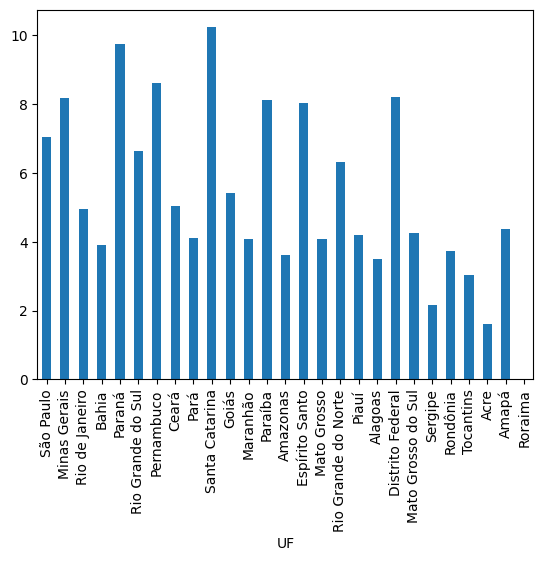

In [22]:
df_populacao_gastos_2024dez['gastos_por_habitante'].plot(kind='bar')

## Desafios
1. Aprimorar o gráfico (título, legenda, eixos, etc)
2. Ordenar do maior para o menor gasto-por-habitante
3. Colocar linha horizontal pela média (atenção de qual número você irá tirar a média)
4. Ordernar por número de habitantes

In [23]:
media_nacional = df_populacao_gastos_2024dez['gastos_total'].sum() / df_populacao_gastos_2024dez['populacao'].sum()

In [24]:
df_populacao_gastos_2024dez = df_populacao_gastos_2024dez.sort_values('populacao', ascending=False);

In [25]:
greater_lower_colors = {
    'greater' : 'orange',
    'lower' : 'blue',
    'equal' : 'cyan'
}

In [26]:
def greater_lower(value, reference):
    if value == reference:
        return 'equal'
    elif value < reference:
        return 'lower'
    else:
        return 'greater'
def convert_to_color(value):
    return greater_lower_colors.get(value, 'gray')

In [27]:
col = df_populacao_gastos_2024dez['gastos_por_habitante'].sort_values(ascending=False).apply(greater_lower, args=(media_nacional,)).apply(convert_to_color)

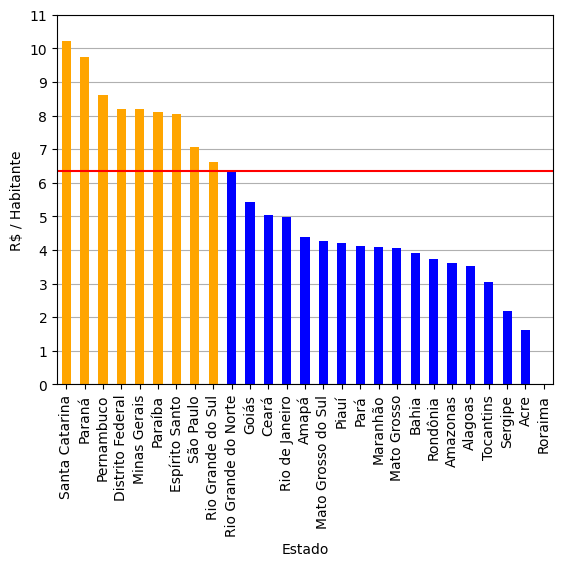

In [28]:
axis = df_populacao_gastos_2024dez['gastos_por_habitante'].sort_values(ascending=False).plot(kind='bar', color=col)
axis.set_xlabel('Estado')
axis.set_yticks(np.arange(0,12,1))
axis.axhline(media_nacional, c='red')
axis.set_ylabel('R$ / Habitante')
axis.set_axisbelow(True)
axis.grid(axis='y')

## Introdução ao Seaborn

<Axes: xlabel='populacao', ylabel='gastos_por_habitante'>

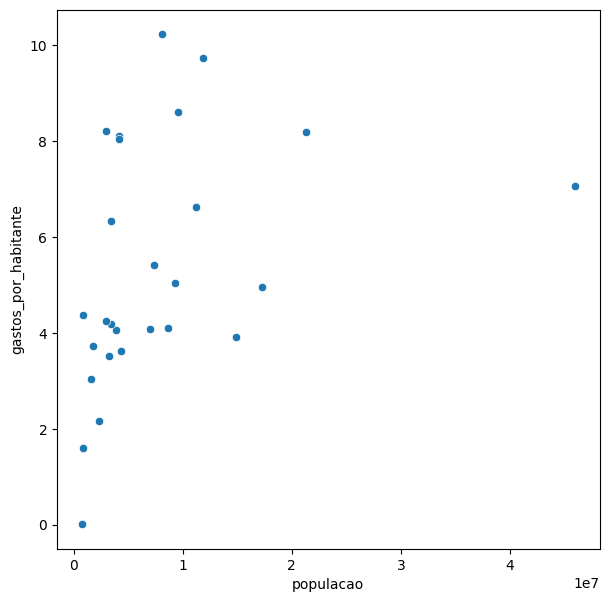

In [29]:
plt.figure(figsize=(7,7))
sns.scatterplot(df_populacao_gastos_2024dez, x='populacao', y='gastos_por_habitante')


## Desafios
- Aprimorar o gráfico
- Executar esse mesmo gráfico para o PENÚLTIMO mês
- Comparar os dois meses no mesmo gráfico, usando cores diferentes

## Segunda metade da aula

In [30]:
df_gastos_2024 *= 1_000_000 # voltando ao numero bruto

In [31]:
def insert_gastos(df_population : pd.DataFrame, df_to_join : pd.DataFrame, month : int):
    # gastos.columns = gastos.columns.map(lambda x: str(x) + '_gastos')
    gastos = df_to_join[df_to_join.columns[month-1]].copy(True)
    gastos.name = 'gastos_' + gastos.name
    df_new = df_population.join(gastos)
    df_new[f'gastos_por_habitante_2024/{month:00d}'] = gastos / df_new['populacao_2024']
    return df_new

In [32]:
df_gastos_2024.index = df_gastos_2024.index.str[3:]

In [33]:
df_gastos_habitantes_2024 = df_populacao
for i in range(1,13):
    df_gastos_habitantes_2024 = insert_gastos(df_gastos_habitantes_2024, df_gastos_2024, i)
df_gastos_habitantes_2024.head(3)

,populacao_2024,gastos_2024/Jan,gastos_por_habitante_2024/1,gastos_2024/Fev,gastos_por_habitante_2024/2,gastos_2024/Mar,gastos_por_habitante_2024/3,gastos_2024/Abr,gastos_por_habitante_2024/4,gastos_2024/Mai,...,gastos_2024/Ago,gastos_por_habitante_2024/8,gastos_2024/Set,gastos_por_habitante_2024/9,gastos_2024/Out,gastos_por_habitante_2024/10,gastos_2024/Nov,gastos_por_habitante_2024/11,gastos_2024/Dez,gastos_por_habitante_2024/12
UF,,,,,,,,,,,,,,,,,,,,,
São Paulo,45973194,399217836.83,8.68,383993834.78,8.35,413529009.01,9.00,433371023.39,9.43,436069689.24,...,442651475.53,9.63,433154845.88,9.42,447928600.94,9.74,387444440.51,8.43,324445311.14,7.06
Minas Gerais,21322691,222875299.37,10.45,211156702.85,9.90,233145944.94,10.93,243167065.29,11.40,244960064.49,...,252154347.59,11.83,253554464.99,11.89,255511700.85,11.98,216701546.87,10.16,174586144.37,8.19
Rio de Janeiro,17219679,126002120.32,7.32,115174946.81,6.69,127679350.65,7.41,132316321.70,7.68,141062368.77,...,145672612.54,8.46,138174217.97,8.02,142773517.13,8.29,109522394.10,6.36,85513544.90,4.97


<Axes: xlabel='populacao_2024', ylabel='gastos_2024/Jan'>

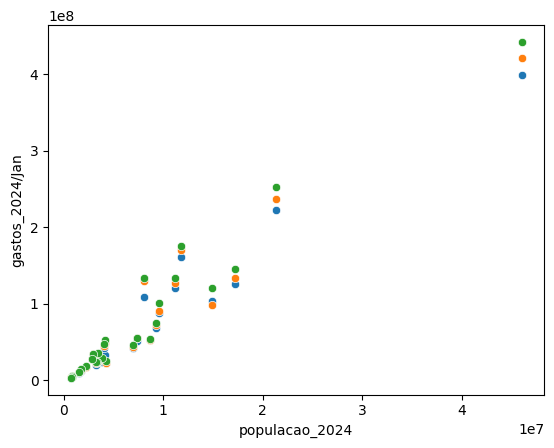

In [34]:
sns.scatterplot(data = df_gastos_habitantes_2024, x = 'populacao_2024', y = 'gastos_2024/Jan')
sns.scatterplot(data = df_gastos_habitantes_2024, x = 'populacao_2024', y = 'gastos_2024/Jun')
sns.scatterplot(data = df_gastos_habitantes_2024, x = 'populacao_2024', y = 'gastos_2024/Ago')

## Desafios
- Legenda
- Diminuir marcações
- Levante alguma hipótese ou questão baseada no gráfico
- Comparar os 12 meses com os 12 anteriores. (Somar os 12 meses em uma coluna só)

# 2.3 Ticks, escalas e formação de imagem

In [35]:
df_gastos_numericos_sem_total = df_gastos_numericos_sem_total.drop(['2007/Ago'],axis=1)

<Axes: xlabel='None', ylabel='35 São Paulo'>

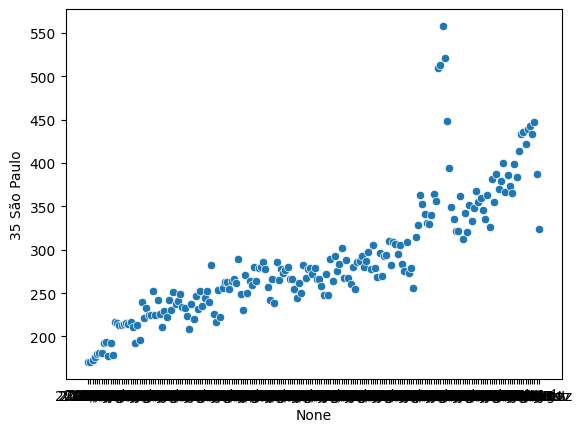

In [36]:
sns.scatterplot(x = df_gastos_numericos_sem_total.columns, y = df_gastos_numericos_sem_total.loc['35 São Paulo'])

In [37]:
df_gastos_mensais = df_gastos_numericos_sem_total.T

In [38]:
colunas = df_gastos_mensais.columns
colunas_new = [x[3:] for x in colunas]
df_gastos_mensais.columns = colunas_new

In [39]:
df_gastos_mensais.head()

,Rondônia,Acre,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,...,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal
2008/Mar,1.96,2.06,8.64,0.88,22.15,1.18,5.20,14.75,10.43,30.09,...,12.26,42.93,170.95,55.61,27.48,52.93,9.79,9.42,20.99,11.63
2008/Abr,2.14,2.06,8.53,0.90,23.44,1.40,5.34,15.15,10.23,31.38,...,12.45,45.32,170.67,56.12,27.81,51.97,9.00,9.39,21.05,11.92
2008/Mai,2.28,2.23,9.08,1.03,23.86,1.41,5.34,14.54,10.56,31.19,...,11.79,43.95,172.81,55.57,28.35,51.68,9.84,9.38,19.16,11.90
2008/Jun,2.62,2.11,8.65,0.94,23.50,1.42,5.40,14.55,10.47,29.46,...,11.89,44.14,175.95,56.09,28.99,53.76,10.26,9.45,20.57,11.97
2008/Jul,2.97,2.03,8.76,1.00,22.54,1.37,5.06,14.54,10.62,30.30,...,12.21,44.36,179.87,59.80,30.05,56.39,10.17,9.79,20.13,11.30


''

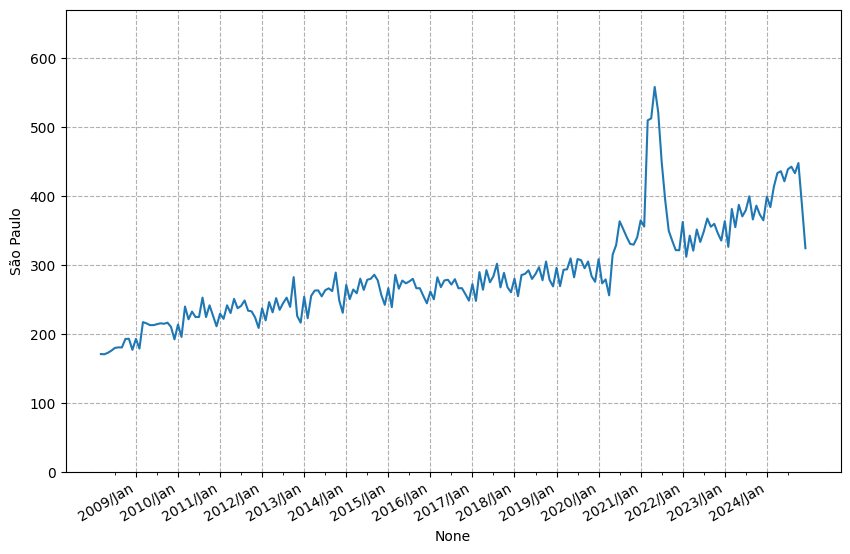

In [40]:
estado = 'São Paulo'
max = df_gastos_mensais[estado].max()

plt.figure(figsize=(10,6))
axis = sns.lineplot(data=df_gastos_mensais, x = df_gastos_mensais.index, y=estado)
plt.xticks(rotation=30, ha='right')

plt.ylim(0, max + max*0.2)


axis.xaxis.set_major_locator(ticker.IndexLocator(base=12, offset=10))
axis.xaxis.set_minor_locator(ticker.IndexLocator(base=12, offset=4))
plt.grid(linestyle='--')
;

## DESAFIOS
- [ ] Fazer o gráfico scatterplot com dois estados, uma cor para cada estado
- [x] Automatizar o limite to eixo Y para que sempre caiba todos os valores da tabela
- [ ] O valor sempre cai em Fevereiro? Qual uma hipótese da razão?
- [x] Colocar um minor locator em Julho

# 2.4 Trabalhando Datetime e Melt
Pandas e seaborn sabem melhor como lidar com o formato DATETIME.

In [107]:
mes_num = {
    'Jan':1,
    'Fev':2,
    'Mar':3,
    'Abr':4,
    'Mai':5,
    'Jun':6,
    'Jul':7,
    'Ago':8,
    'Set':9,
    'Out':10,
    'Nov':11,
    'Dez':12
}

mes_dias = {
    1:31,
    2:28,
    3:31,
    4:30,
    5:31,
    6:30,
    7:31,
    8:31,
    9:30,
    10:31,
    11:30,
    12:31
}

In [ ]:
df_gastos_mensais.index = df_gastos_mensais.index.map(lambda x : date(int(x[:4]), mes_num[x[5:]], 1))

''

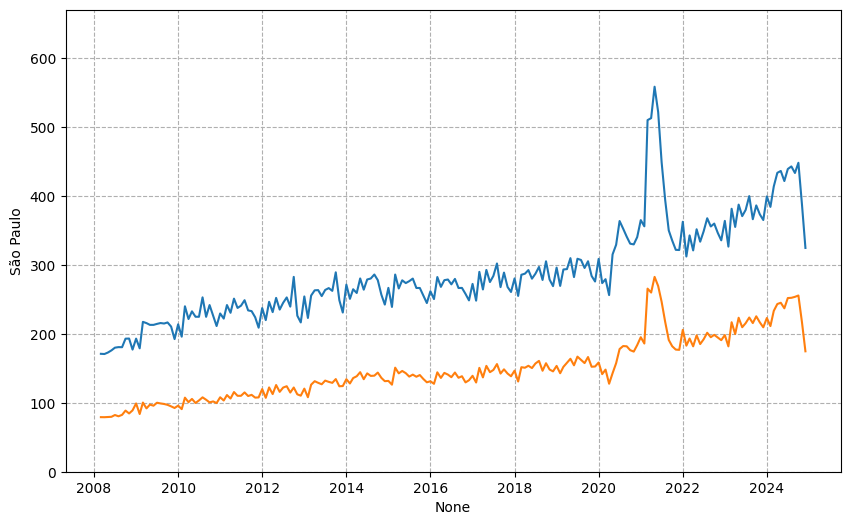

In [42]:
estado = 'São Paulo'
max = df_gastos_mensais[estado].max()

plt.figure(figsize=(10,6))
axis = sns.lineplot(data=df_gastos_mensais, x = df_gastos_mensais.index, y=estado)

estado = 'Minas Gerais'
axis = sns.lineplot(data=df_gastos_mensais, x = df_gastos_mensais.index, y=estado)
# plt.xticks(rotation=30, ha='right')

plt.ylim(0, max + max*0.2)
plt.grid(linestyle='--')
;

## Transformando essa nossa tabela de uma maneira que 'estado' vire uma CATEGORIA

In [51]:
df_gastos_mensais_melt = df_gastos_mensais.reset_index().melt(id_vars=['index'], value_vars=df_gastos_mensais.columns) 
# id_vars = vão ficar fixas, value_vars = vão 'abrir'
df_gastos_mensais_melt.columns = ['data','uf', 'gasto']
df_gastos_mensais_melt.head(2)

,data,uf,gasto
0,2008-03-01,Rondônia,1.96
1,2008-04-01,Rondônia,2.14


In [60]:
# processo reverso: 
df_gastos_mensais_melt.pivot_table(values = 'gasto', index='data', columns='uf').reset_index().head(2)

uf,data,Acre,Alagoas,Amapá,Amazonas,Bahia,Ceará,Distrito Federal,Espírito Santo,Goiás,...,Piauí,Rio Grande do Norte,Rio Grande do Sul,Rio de Janeiro,Rondônia,Roraima,Santa Catarina,Sergipe,São Paulo,Tocantins
0,2008-03-01,2.06,9.21,1.18,8.64,41.42,30.09,11.63,12.26,20.99,...,10.43,10.13,52.93,42.93,1.96,0.88,27.48,5.02,170.95,5.20
1,2008-04-01,2.06,10.47,1.40,8.53,42.83,31.38,11.92,12.45,21.05,...,10.23,10.96,51.97,45.32,2.14,0.90,27.81,5.27,170.67,5.34


In [79]:
filtrado = df_gastos_mensais_melt[(df_gastos_mensais_melt['uf'] == 'São Paulo') | (df_gastos_mensais_melt['uf'] == 'Minas Gerais')]

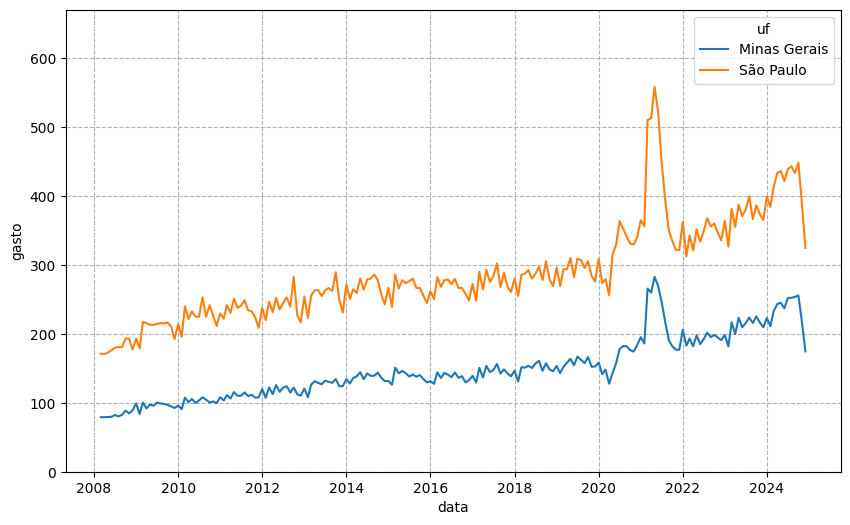

In [80]:
plt.figure(figsize=(10,6))
axis = sns.lineplot(data=filtrado, x='data', y='gasto',hue='uf')
plt.ylim(0, max + max*0.2)
plt.grid(linestyle='--')

## DESAFIOS
- [x] Como fazer o processo reverso (desfazer o melt)?
- [x] Fazer o acima com dois estados apenas

# 2.5 Manipulando datas e gerando novas análises

## Tendência ANO A ANO

In [ ]:
df_gastos_mensais_melt['data'][0].year # datetime tem suas próprias funcoes e atributos que podemos acessar

2008

In [ ]:
df_gastos_mensais_melt['data'] = df_gastos_mensais_melt['data'].astype('datetime64[ns]')
# ou: pd.to_datetime(coluna)

In [97]:
df_gastos_mensais_melt['mes'] = df_gastos_mensais_melt['data'].dt.month # .dt é como o .str, trata essa série como um tipo de variável, nesse caso datetime
df_gastos_mensais_melt['ano'] = df_gastos_mensais_melt['data'].dt.year
df_gastos_mensais_melt.head(2)

,data,uf,gasto,mes,ano
0,2008-03-01,Rondônia,1.96,3,2008
1,2008-04-01,Rondônia,2.14,4,2008


Filtrando:

In [99]:
df_gastos_mensais_melt[df_gastos_mensais_melt['uf'] == 'São Paulo'].head(2)
# ou: .query('uf=="São Paulo"')

,data,uf,gasto,mes,ano
3838,2008-03-01,São Paulo,170.95,3,2008
3839,2008-04-01,São Paulo,170.67,4,2008


(0.0, 669.84989058)

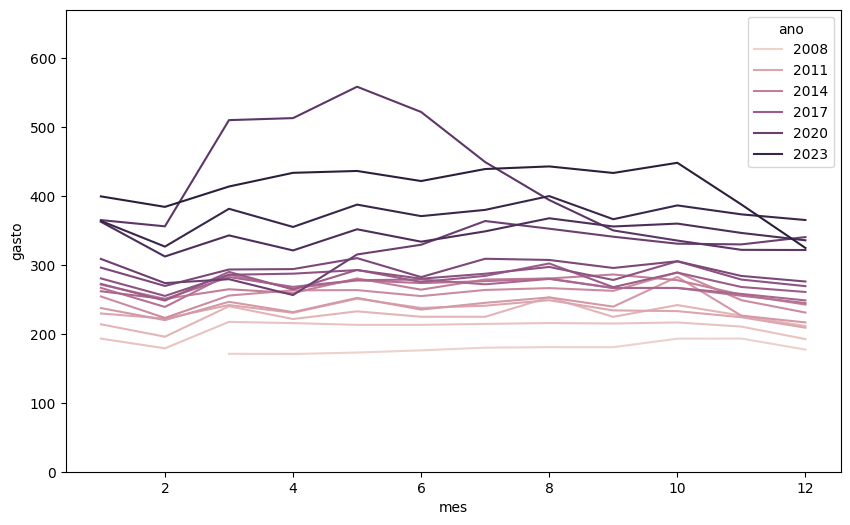

In [102]:
plt.figure(figsize=(10,6))
axis = sns.lineplot(data=df_gastos_mensais_melt[df_gastos_mensais_melt['uf'] == 'São Paulo'], x = 'mes', y = 'gasto', hue = 'ano')
plt.ylim(0,max+max*0.2)

In [111]:
df_gastos_mensais_melt['gasto_diario'] = df_gastos_mensais_melt['gasto'] / df_gastos_mensais_melt['mes'].map(mes_dias)

(0.0, 25.0)

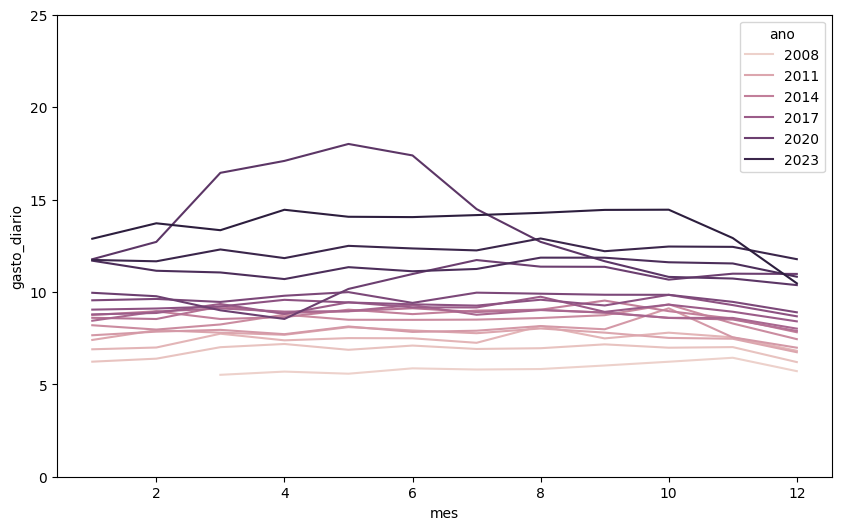

In [115]:
plt.figure(figsize=(10,6))
axis = sns.lineplot(data=df_gastos_mensais_melt[df_gastos_mensais_melt['uf'] == 'São Paulo'], x = 'mes', y = 'gasto_diario', hue = 'ano')
plt.ylim(0,25)

## Desafio
- [ ] Escolher um ano e plotar ele para dois estados diferentes
    - [ ] Considerar a população dos dois estados e calcule o gasto por pessoa no ano atual
- [ ] Melhorar: cores, tiítulos, ticks, grid, nomes dos meses
- [ ] Levar anos bissextos em consideração